In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

#Program that executes the rolling window train-val-test split 
%run TimeBasedCV.ipynb

In [2]:
#Read in the cleansed and winsorised data
df = pd.read_csv(r"C:\Users\krist\Documents\Data\ger_factor_data_from2003.csv", dtype ={"comp_tpci": str}, parse_dates =["eom"])
#Convert to float 32 (format needed for the most ML models)
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
#Sort observations by date and stock id
df = df.sort_values(by = ['eom', 'id'], ascending = True)
df.head()

,id,eom,prc,me,ret,ret_exc,ret_exc_lead1m,ret_6_1,ret_12_1,tax_gr1a,...,cowc_gr1a,pi_nix,ret_6_0,ret_1_0,noa_at,cop_atl1,prc_highprc_252d,ocf_at,dbnetis_at,netdebt_me
0,comp_001166_02W,2003-01-31,11.486148,567.074646,-0.018948,-0.019948,-0.089504,-0.229560,-0.353251,-0.020556,...,0.041844,3.815513,-0.244158,-0.018948,0.692706,0.093015,0.398130,-0.007700,0.085202,0.135368
1,comp_001661_01W,2003-01-31,35.853958,5221.931641,0.005815,0.004815,0.108428,0.129149,-0.035109,-0.033306,...,-0.019596,1.284930,0.135715,0.005815,0.751569,0.164124,0.918059,0.096164,0.063714,0.200036
2,comp_004367_02W,2003-01-31,36.068653,4139.599121,-0.103801,-0.104801,0.127227,-0.020286,0.087151,-0.037240,...,0.026114,1.725004,-0.121981,-0.103801,0.961141,0.240563,0.675468,0.070724,-0.000607,0.410184
3,comp_004925_02W,2003-01-31,29.735168,15302.482422,-0.070425,-0.071425,0.064832,0.046064,0.023265,-0.007344,...,-0.000724,1.961724,-0.027605,-0.070425,0.466852,0.221983,0.861333,0.084234,-0.008142,-0.075232
4,comp_005959_01W,2003-01-31,39.181721,6355.691406,-0.085813,-0.086813,0.001832,0.123795,0.012811,-0.012241,...,-0.014214,1.069862,0.027359,-0.085813,0.635742,0.108581,0.721256,0.069331,-0.038594,0.500641


In [3]:
#Copy date variable and stock id to use them as multindex
df["id2"] = df["id"].copy()
df["eom2"] = df["eom"].copy()
df = df.set_index(['eom2','id2'])

#Make a copy of  the "me" variable (market equity) before rank standartization to use afterwards for value weighting
df["me2"] = df["me"].copy()

To investigate the potential heterogeneity in model predictability, a subgroup analysis for small (the bottom 30% stocks by market equity each month) and large (the top 30% stocks each month) stocks is reported.

In [4]:
#Create two new dataframes containing only large and only small firms respectively.
p=0.3 
df_top = df.groupby('eom').apply(lambda x: x.nlargest(int(len(x)*p),"me")).reset_index(drop=True)  
df_bottom = df.groupby('eom').apply(lambda x: x.nsmallest(int(len(x)*p),"me")).reset_index(drop=True)

### Rank standardization  in interval [-1,1]

A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [5]:
#Standardize all independent variables
features = df.columns[~df.columns.isin(["eom","eom2","me2",'id',"id2","ret","ret_exc","ret_exc_lead1m"])].tolist()

#Ranks in [0,1]interval
df[features]=df.groupby("eom")[features].rank(pct=True)

#Multiply by 2 and substract 1 to get ranks in interval [-1,1] 
df[features] = 2*df[features] - 1

In [6]:
#Standardize the big firms dataset
features = df_top.columns[~df_top.columns.isin(["eom","eom2","me2",'id',"id2","ret","ret_exc","ret_exc_lead1m"])].tolist()
df_top[features]=df_top.groupby("eom")[features].rank(pct=True)
df_top[features] = 2*df_top[features] - 1

In [7]:
#standardize the small firms dataset
features = df_bottom.columns[~df_bottom.columns.isin(["eom","eom2","me2",'id',"id2","ret","ret_exc","ret_exc_lead1m"])].tolist()
df_bottom[features]=df_bottom.groupby("eom")[features].rank(pct=True)
df_bottom[features] = 2*df_bottom[features] - 1

# Principal component regression

## All firms

In [8]:
# Define the splitting pscheme:
# Rolling window  train-val-test split
# The rolling window is set to 96 months (8 years)
# 5 years for training, 2 years for validation, and 1 year for out-of-samlpe testing
tscv = TimeBasedCV(train_period=60,
                   val_period=24,
                   test_period=12,
                   freq='months')

#Define the idependent variables (X) and the dependent variable (y)
features = df.columns[~df.columns.isin(['id',"id2","me2","prc","eom2","ret","ret_exc","ret_exc_lead1m"])].tolist()
X = df[features]
y = df["ret_exc_lead1m"]


#Empty containers to save results from each window
predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}

# Model’s complexity: dictionary to save the number of components over time
numpc_time = {}

# List of prespecified values to use to determine the optimal number of components 

numpc = [1,2,3,5,7,9,11,15,17,22,25,29,33,40,45,49]
# Empty container to save the objective loss function (mean squared errors) for each number of components
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(2008,1,31), second_split_date= datetime.date(2010,1,31)):

    X_train   = X.loc[train_index].drop('eom', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('eom', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('eom', axis=1)
    y_test  = y.loc[test_index]
    
    
    # In Sklearn there is no PCR class, so one has to first perform the dimention reduction using Principal
    # component analysis and than proceed with prediction using linear regression
    
    #Loop over the list containing potential number of components, fit on the training sample and use 
    #validation set to generate predictions
    for i in range(len(numpc)):
        pca_val = PCA(n_components = numpc[i])
        # Run PCA producing the reduced variable X_reduced_val containing i components
        X_reduced_train = pca_val.fit_transform(X_train)
        X_reduced_val = pca_val.transform(X_val)
        # Create linear regression object and fit
        line_fitter_val = LinearRegression()
        line_fitter_val.fit(X_reduced_train, y_train)
        # Predict using the reduced variable
        Yval_predict=line_fitter_val.predict(X_reduced_val)
        #calculate mean squared error for each potential value of the numpc hyperparameter
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

        
    #The optimal value of the numpc hyperparameter is the value that causes the lowest loss   
    optim_numpc = numpc[np.argmin(mse)]

    #Fit again using the train and validation set and the optimal numpc parameter  
    pca = PCA(n_components = optim_numpc)
    principalComponents = pca.fit_transform(np.concatenate((X_train, X_val)))
    X_reduced_test = pca.transform(X_test)    
    line_fitter = LinearRegression()
    line_fitter.fit(principalComponents, (np.concatenate((y_train, y_val))))
    #Use test set to generate final predictions using the redused variable
    preds=line_fitter.predict(X_reduced_test)
    
    
    #Save predictions, dates and the true values of the dependent variable to list  
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    #Calculate OOS model performance the for current window
    r2 = 1-sum(pow(y_test-preds,2))/sum(pow(y_test,2))
    #Save OOS model performance and the respective month to dictionary
    dic_r2_all["r2." + str(y_test.index)] = r2
    # Save the number of components to inspect  model's complexity over time 
    numpc_time["numpc." + str(y_test.index)] = optim_numpc

  
        
#Concatenate to get results over the whole OOS test period (Jan 2010-Dec 2019)
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
R2OOS_PCR = 1-sum(pow(y_test_list_all-predictions_all,2))/sum(pow(y_test_list_all,2))
print("R2OOS principal component regression: ", R2OOS_PCR)


Train period: 2003-01-31 - 2008-01-31 ,val period: 2008-01-31 - 2010-01-31 , Test period 2010-01-31 - 2011-01-31 # train records 37757 ,# val records 17356 , # test records 8974
Train period: 2004-01-31 - 2009-01-31 ,val period: 2009-01-31 - 2011-01-31 , Test period 2011-01-31 - 2012-01-31 # train records 40925 ,# val records 17143 , # test records 9537
Train period: 2005-01-31 - 2010-01-31 ,val period: 2010-01-31 - 2012-01-31 , Test period 2012-01-31 - 2013-01-31 # train records 42278 ,# val records 18511 , # test records 9107
Train period: 2006-01-31 - 2011-01-31 ,val period: 2011-01-31 - 2013-01-31 , Test period 2013-01-31 - 2014-01-31 # train records 43971 ,# val records 18644 , # test records 9636
Train period: 2007-01-31 - 2012-01-31 ,val period: 2012-01-31 - 2014-01-31 , Test period 2014-01-31 - 2015-01-31 # train records 45267 ,# val records 18743 , # test records 9919
Train period: 2008-01-31 - 2013-01-31 ,val period: 2013-01-31 - 2015-01-31 , Test period 2015-01-31 - 2016-01-

# Big only 

In [14]:
tscv = TimeBasedCV(train_period=60,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df_top.columns[~df_top.columns.isin(['id',"id2","me2","prc","eom2","ret","ret_exc","ret_exc_lead1m"])].tolist()
X = df_top[features]
y = df_top["ret_exc_lead1m"]


#Empty containers to save results from each window
predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

numpc = [1,2,3,5,7,9,11,15,17,22,25,29,33,40,45,49]
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(2008,1,31), second_split_date= datetime.date(2010,1,31)):

    X_train   = X.loc[train_index].drop('eom', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('eom', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('eom', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pca_val = PCA(n_components = numpc[i])
        X_reduced_train = pca_val.fit_transform(X_train)
        X_reduced_val = pca_val.transform(X_val)
        line_fitter_val = LinearRegression()
        line_fitter_val.fit(X_reduced_train, y_train)
        Yval_predict=line_fitter_val.predict(X_reduced_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

         
    optim_numpc = numpc[np.argmin(mse)]

    pca = PCA(n_components = optim_numpc)
    principalComponents = pca.fit_transform(np.concatenate((X_train, X_val)))
    X_reduced_test = pca.transform(X_test)
    line_fitter = LinearRegression()
    line_fitter.fit(principalComponents, (np.concatenate((y_train, y_val))))
    preds=line_fitter.predict(X_reduced_test)

    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    

    r2 = 1-sum(pow(y_test-preds,2))/sum(pow(y_test,2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2

  
        
predictions_all_top_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)


R2OOS_PCR_top = 1-sum(pow(y_test_list_all_top-predictions_all_top_top,2))/sum(pow(y_test_list_all_top,2))
print("R2OOS principal component regression Big only: ", R2OOS_PCR_top)



Train period: 2003-01-31 - 2008-01-31 ,val period: 2008-01-31 - 2010-01-31 , Test period 2010-01-31 - 2011-01-31 # train records 11301 ,# val records 5199 , # test records 2687
Train period: 2004-01-31 - 2009-01-31 ,val period: 2009-01-31 - 2011-01-31 , Test period 2011-01-31 - 2012-01-31 # train records 12252 ,# val records 5135 , # test records 2855
Train period: 2005-01-31 - 2010-01-31 ,val period: 2010-01-31 - 2012-01-31 , Test period 2012-01-31 - 2013-01-31 # train records 12661 ,# val records 5542 , # test records 2728
Train period: 2006-01-31 - 2011-01-31 ,val period: 2011-01-31 - 2013-01-31 , Test period 2013-01-31 - 2014-01-31 # train records 13170 ,# val records 5583 , # test records 2885
Train period: 2007-01-31 - 2012-01-31 ,val period: 2012-01-31 - 2014-01-31 , Test period 2014-01-31 - 2015-01-31 # train records 13558 ,# val records 5613 , # test records 2969
Train period: 2008-01-31 - 2013-01-31 ,val period: 2013-01-31 - 2015-01-31 , Test period 2015-01-31 - 2016-01-31 # 

# Small only

In [13]:
tscv = TimeBasedCV(train_period=60,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df_bottom.columns[~df_bottom.columns.isin(['id',"id2","me2","prc","eom2","ret","ret_exc","ret_exc_lead1m"])].tolist()
X = df_bottom[features]
y = df_bottom["ret_exc_lead1m"]


#Empty containers to save results from each window
predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}

numpc = [1,2,3,5,7,9,11,15,17,22,25,29,33,40,45,49]
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(2008,1,31), second_split_date= datetime.date(2010,1,31)):

    X_train   = X.loc[train_index].drop('eom', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('eom', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('eom', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pca_val = PCA(n_components = numpc[i])
        X_reduced_train = pca_val.fit_transform(X_train)
        X_reduced_val = pca_val.transform(X_val)
        line_fitter_val = LinearRegression()
        line_fitter_val.fit(X_reduced_train, y_train)
        Yval_predict=line_fitter_val.predict(X_reduced_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))


         
    optim_numpc = numpc[np.argmin(mse)]

    pca = PCA(n_components = optim_numpc)
    principalComponents = pca.fit_transform(np.concatenate((X_train, X_val)))
    X_reduced_test = pca.transform(X_test)
    line_fitter = LinearRegression()
    line_fitter.fit(principalComponents, (np.concatenate((y_train, y_val))))
    preds=line_fitter.predict(X_reduced_test)

    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    

    r2 = 1-sum(pow(y_test-preds,2))/sum(pow(y_test,2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2

  
        
predictions_all_bottom_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)


R2OOS_PCR_bottom = 1-sum(pow(y_test_list_all_bottom-predictions_all_bottom_bottom,2))/sum(pow(y_test_list_all_bottom,2))
print("R2OOS principal component regression Small only: ", R2OOS_PCR_bottom)



Train period: 2003-01-31 - 2008-01-31 ,val period: 2008-01-31 - 2010-01-31 , Test period 2010-01-31 - 2011-01-31 # train records 11301 ,# val records 5199 , # test records 2687
Train period: 2004-01-31 - 2009-01-31 ,val period: 2009-01-31 - 2011-01-31 , Test period 2011-01-31 - 2012-01-31 # train records 12252 ,# val records 5135 , # test records 2855
Train period: 2005-01-31 - 2010-01-31 ,val period: 2010-01-31 - 2012-01-31 , Test period 2012-01-31 - 2013-01-31 # train records 12661 ,# val records 5542 , # test records 2728
Train period: 2006-01-31 - 2011-01-31 ,val period: 2011-01-31 - 2013-01-31 , Test period 2013-01-31 - 2014-01-31 # train records 13170 ,# val records 5583 , # test records 2885
Train period: 2007-01-31 - 2012-01-31 ,val period: 2012-01-31 - 2014-01-31 , Test period 2014-01-31 - 2015-01-31 # train records 13558 ,# val records 5613 , # test records 2969
Train period: 2008-01-31 - 2013-01-31 ,val period: 2013-01-31 - 2015-01-31 , Test period 2015-01-31 - 2016-01-31 # 

In [12]:
#Generate table containing the R2oos measures for all three datasets
chart = np.array([[R2OOS_PCR],
                  [R2OOS_PCR_top],
                  [R2OOS_PCR_bottom]])
                     

r2oos_pcr = pd.DataFrame(chart, columns=['PCR'],
                              index=["Full sample", "Large firms", "Small firms"])
r2oos_pcr

,PCR
Full sample,0.008066
Large firms,0.006243
Small firms,0.010347


In [13]:
#Save the model's performance measures to compare with other models later.
r2oos_pcr.to_csv(r'C:\Users\krist\Documents\Data\r2oos results\r2oos_pcr.csv')

### Time-varying model complexity

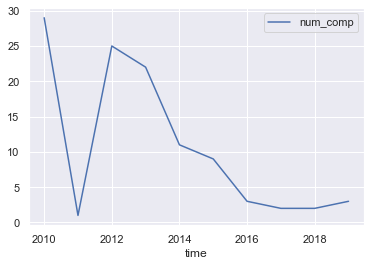

In [24]:
# Convert dictionary containing the number of components over time in dataframe
pd.DataFrame(numpc_time.items())
numpc_table =pd.DataFrame(numpc_time.items(), columns=['Identifier', 'num_comp'])
numpc_table['Identifier'] = numpc_table['Identifier'].astype(str)
numpc_table["time"] = numpc_table["Identifier"].str[20:30]
numpc_table["time"] = pd.to_datetime(numpc_table["time"], utc = False)
numpc_table["time"] = numpc_table["time"].dt.year
numpc_table.drop(["Identifier"], axis = 1, inplace = True)

#Plot time-varying model complexity
numpc_table.set_index('time').plot();
#plt.xticks(rotation=45);


In [25]:
#Save the model's complexity  to compare with other models later.
numpc_table.to_csv(r'C:\Users\krist\Documents\Data\model_complexity\comp_pcr.csv')

### Variable Importance

Variable importance is defined following Gu et al. (2020), i.e., for each model, all values of a given predictor are set to zero and the reduction in predictive R2OOS is calculated. Then, the absolute reductions in predictive R2OOS are normalized to sum to 1, indicating the relative contribution of each variable to a model. In contrast to Gu et al. (2020), variable importance is calculated based on the last rolling window observation sample and does not represent an average over the whole sample.  


In [39]:
# R2OOS based on the last rolling window when all variables are included
features = df.columns[~df.columns.isin(['id',"id2","eom","eom2","me2","prc","ret","ret_exc","ret_exc_lead1m","year"])].tolist()
df["year"] = df["eom"].dt.year

X_train = df[features].loc[(df["year"]>=2012) & (df["year"]<=2016)]
y_train = df["ret_exc_lead1m"].loc[(df["year"]>=2012) & (df["year"]<=2016)]

X_val = df[features].loc[(df["year"]>=2017) & (df["year"]<=2018)]
y_val = df["ret_exc_lead1m"].loc[(df["year"]>=2017) & (df["year"]<=2018)]

numpc = [1,2,3,5,7,9,11,15,17,22,25,29,33,40,45,49]
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)

for i in range(len(numpc)):
    pca_val = PCA(n_components = numpc[i])
    X_reduced_train = pca_val.fit_transform(X_train)
    X_reduced_val = pca_val.transform(X_val)
    line_fitter_val = LinearRegression()
    line_fitter_val.fit(X_reduced_train, y_train)
    Yval_predict=line_fitter_val.predict(X_reduced_val)
    mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

         
optim_numpc = numpc[np.argmin(mse)]
pca = PCA(n_components = optim_numpc)
principalComponents = pca.fit_transform(np.concatenate((X_train, X_val)))
line_fitter = LinearRegression()
line_fitter.fit(principalComponents, (np.concatenate((y_train, y_val))))
preds=line_fitter.predict(principalComponents)
R2OOS_all = 1-sum(pow(np.concatenate((y_train, y_val))-preds,2))/sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)



0.008041589337524191


In [40]:
# Generate a separate dataframe for each independent variable, where all values of that variable are set to zero

for j in features:
    globals()['df_' + str(j)] =  df.copy()
    globals()['df_' + str(j)][str(j)] = 0

In [41]:
#e.g., df_ret_12_1 is a dataframe where all values of the ret_12_1 variable are set to zero
df_ret_12_1

id        eom       prc        me  \
eom2       id2                                                               
2003-01-31 comp_001166_02W  comp_001166_02W 2003-01-31 -0.376652  0.162996   
           comp_001661_01W  comp_001661_01W 2003-01-31  0.427313  0.718062   
           comp_004367_02W  comp_004367_02W 2003-01-31  0.433921  0.674009   
           comp_004925_02W  comp_004925_02W 2003-01-31  0.295154  0.881057   
           comp_005959_01W  comp_005959_01W 2003-01-31  0.477974  0.762115   
...                                     ...        ...       ...       ...   
2020-12-31 comp_333885_01W  comp_333885_01W 2020-12-31  0.367156  0.484646   
           comp_334302_02W  comp_334302_02W 2020-12-31 -0.842457 -0.487316   
           comp_335706_02W  comp_335706_02W 2020-12-31 -0.722296 -0.618158   
           comp_340115_01W  comp_340115_01W 2020-12-31 -0.392523 -0.025367   
           comp_340153_01W  comp_340153_01W 2020-12-31  0.138852  0.711615   

                                 ret   ret_exc  ret_exc_lead1m   ret_6_1  \
eom2       id2                                                             
2003-01-31 comp_001166_02W -0.018948 -0.019948       -0.089504 -0.665198   
           comp_001661_01W  0.005815  0.004815        0.108428  0.669604   
           comp_004367_02W -0.103801 -0.104801        0.127227  0.114537   
           comp_004925_02W -0.070425 -0.071425        0.064832  0.392070   
           comp_005959_01W -0.085813 -0.086813        0.001832  0.643172   
...                              ...       ...             ...       ...   
2020-12-31 comp_333885_01W  0.128645  0.128545       -0.037398 -0.957276   
           comp_334302_02W  0.097961  0.097861       -0.033670 -0.420561   
           comp_335706_02W  0.114381  0.114281        0.089684  0.097463   
           comp_340115_01W  0.155813  0.155713        0.009796  0.001335   
           comp_340153_01W  0.238817  0.238717        0.006943  0.001335   

                            ret_12_1  tax_gr1a  ...   ret_6_0   ret_1_0  \
eom2       id2                                  ...                       
2003-01-31 comp_001166_02W         0 -0.726872  ... -0.669604 -0.312775   
           comp_001661_01W         0 -0.845815  ...  0.577093 -0.110132   
           comp_004367_02W         0 -0.894273  ... -0.356828 -0.766520   
           comp_004925_02W         0 -0.453744  ...  0.096916 -0.612335   
           comp_005959_01W         0 -0.599119  ...  0.259912 -0.691630   
...                              ...       ...  ...       ...       ...   
2020-12-31 comp_333885_01W         0 -0.951936  ... -0.853138  0.591455   
           comp_334302_02W         0  0.540721  ... -0.268358  0.417891   
           comp_335706_02W         0  0.311081  ...  0.236315  0.511348   
           comp_340115_01W         0  0.871829  ...  0.001335  0.687583   
           comp_340153_01W         0  0.847797  ...  0.001335  0.879840   

                              noa_at  cop_atl1  prc_highprc_252d    ocf_at  \
eom2       id2                                                               
2003-01-31 comp_001166_02W  0.585903 -0.735683         -0.859031 -0.797357   
           comp_001661_01W  0.696035 -0.392070          0.607930  0.286344   
           comp_004367_02W  0.881057  0.458150         -0.365639 -0.110132   
           comp_004925_02W -0.264317  0.330396          0.422907  0.149780   
           comp_005959_01W  0.458150 -0.669604         -0.255507 -0.118943   
...                              ...       ...               ...       ...   
2020-12-31 comp_333885_01W  0.457944  0.815754         -0.319092  0.877170   
           comp_334302_02W  0.791722  0.345794          0.754339  0.054740   
           comp_335706_02W -0.241656 -0.935915         -0.313752 -0.917223   
           comp_340115_01W -0.415220 -0.436582          0.001335  0.025367   
           comp_340153_01W -0.815754 -0.636849          0.001335 -0.129506   

                            dbnetis_at  netdeb

In [42]:
# calculate R2OOS based on the last rolling window for each dataframe and save to dictionary

dic = {}    
numpc =np.arange(2, 20, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)
    
for j in features:
    df_var = globals()['df_' + str(j)]
    
    X_train = df_var[features].loc[(df_var["year"]>=2012) & (df_var["year"]<=2016)]
    y_train = df_var["ret_exc_lead1m"].loc[(df_var["year"]>=2012) & (df_var["year"]<=2016)]

    X_val = df_var[features].loc[(df_var["year"]>=2017) & (df_var["year"]<=2018)]
    y_val = df_var["ret_exc_lead1m"].loc[(df_var["year"]>=2017) & (df_var["year"]<=2018)]

    
    for i in range(len(numpc)):
        pca_val = PCA(n_components = numpc[i])
        X_reduced_train = pca_val.fit_transform(X_train)
        X_reduced_val = pca_val.transform(X_val)
        line_fitter_val = LinearRegression()
        line_fitter_val.fit(X_reduced_train, y_train)
        Yval_predict=line_fitter_val.predict(X_reduced_val)
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

         
    optim_numpc = numpc[np.argmin(mse)]
    pca = PCA(n_components = optim_numpc)
    principalComponents = pca.fit_transform(np.concatenate((X_train, X_val)))
    line_fitter = LinearRegression()
    line_fitter.fit(principalComponents, (np.concatenate((y_train, y_val))))
    preds=line_fitter.predict(principalComponents)    
    R2OOS_var = 1-sum(pow(np.concatenate((y_train, y_val))-preds,2))/sum(pow(np.concatenate((y_train, y_val)),2))
    dic['R2OOS_' + str(j)] = R2OOS_var

In [43]:
# dictionary, containing OOS predictive R2, when the all values of a given predictor are set to zero
dic

{'R2OOS_me': 0.007882220039139964,
 'R2OOS_ret_6_1': 0.008586615999087055,
 'R2OOS_ret_12_1': 0.010370354590459319,
 'R2OOS_tax_gr1a': 0.007978826799963645,
 'R2OOS_be_me': 0.008288464095017045,
 'R2OOS_debt_me': 0.008631007521485379,
 'R2OOS_ni_me': 0.007984778018852445,
 'R2OOS_sale_gr3': 0.007874781125965735,
 'R2OOS_sale_gr1': 0.00784479918724379,
 'R2OOS_sale_me': 0.008299388634497529,
 'R2OOS_lnoa_gr1a': 0.0078019205425843285,
 'R2OOS_inv_gr1a': 0.007898867883029737,
 'R2OOS_oaccruals_at': 0.008941151477232179,
 'R2OOS_taccruals_at': 0.007747618429569503,
 'R2OOS_be_gr1a': 0.007906715343042992,
 'R2OOS_taccruals_ni': 0.00910221401604916,
 'R2OOS_ebit_sale': 0.007962942569583187,
 'R2OOS_sale_bev': 0.007977620633951465,
 'R2OOS_age': 0.007941142206918772,
 'R2OOS_beta_60m': 0.00804514105843046,
 'R2OOS_rmax1_21d': 0.007815170517090797,
 'R2OOS_bidaskhl_21d': 0.007816242034879517,
 'R2OOS_ret_9_1': 0.008364546881691193,
 'R2OOS_ret_12_7': 0.00883128264109212,
 'R2OOS_ni_be': 0.0090

In [44]:
# Convert dictionary to dataframe
pd.DataFrame(dic.items())
imp=pd.DataFrame(dic.items(), columns=['Feature', 'R2OOS'])
# Feature: name of the variable whose values are set to zero
imp["Feature"] = imp["Feature"].str[6:]

# Calculate reduction in predictive R2OOS 
imp["red_R2OOS"] = R2OOS_all -imp["R2OOS"]
imp["var_imp"] = imp["red_R2OOS"]/sum(imp["red_R2OOS"])
imp=imp.sort_values(by = ['var_imp'], ascending = False)
imp

,Feature,R2OOS,red_R2OOS,var_imp
2,ret_12_1,0.010370,-0.002329,0.316949
15,taccruals_ni,0.009102,-0.001061,0.144353
33,ope_be,0.009065,-0.001023,0.139227
24,ni_be,0.009038,-0.000997,0.135675
12,oaccruals_at,0.008941,-0.000900,0.122432
23,ret_12_7,0.008831,-0.000790,0.107479
41,ret_6_0,0.008641,-0.000600,0.081629
5,debt_me,0.008631,-0.000589,0.080221
1,ret_6_1,0.008587,-0.000545,0.074179
48,netdebt_me,0.008513,-0.000472,0.064213


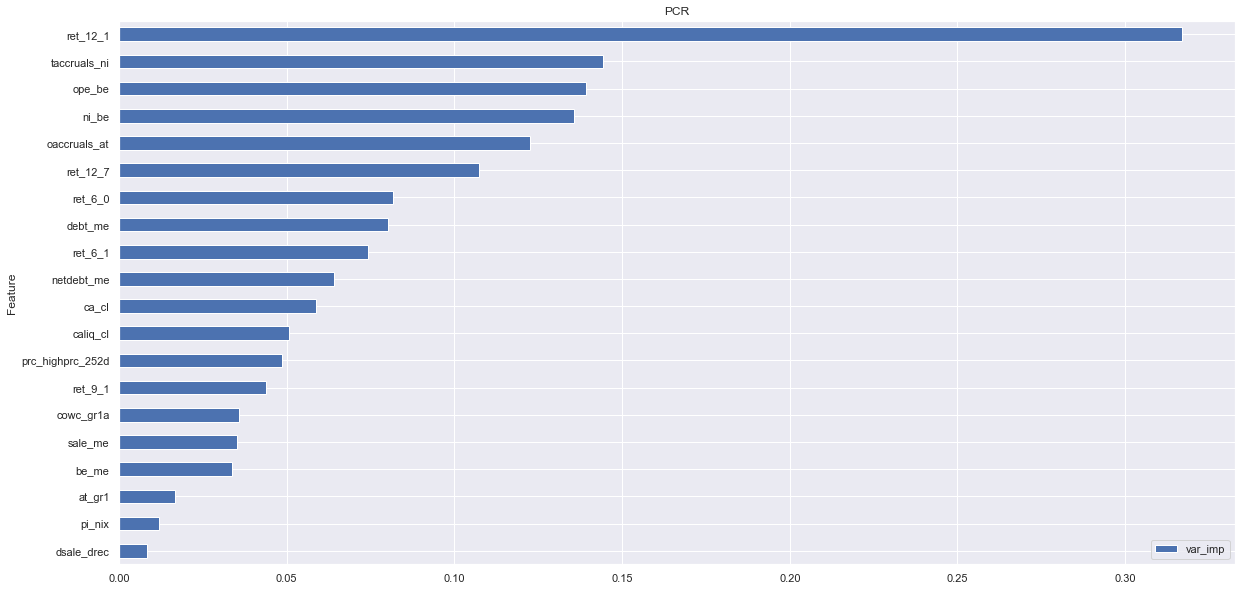

In [45]:
# Plot variable importance measures for the top-20 most influential variables

fea_imp_graph = imp.sort_values(['var_imp', 'Feature'], ascending=[True, False]).iloc[-20:]
_ = fea_imp_graph.plot(kind='barh', x='Feature', y='var_imp', figsize=(20, 10))
plt.title('PCR')
plt.show()


In [46]:
var_imp_pcr=imp[["Feature", "var_imp"]]
var_imp_pcr.to_csv(r'C:\Users\krist\Documents\Data\variable importance\var_imp_pcr.csv', index = False)

# Machine learning portfolios

Explore whether predictability translates into portfolio gains

In [9]:
#Generate a results dataframe containing the model predictions (yhat) and the true values (y_true) 
#of the dependent variable for each stock in each month

yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[36:51]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results

yhat    y_true       date
MonthYear id                                            
2010-01   comp_001166_02W  0.015672  0.035512 2010-01-31
          comp_001661_01W  0.013568 -0.041371 2010-01-31
          comp_002410_04W  0.011608 -0.053836 2010-01-31
          comp_002597_02W  0.010799  0.001862 2010-01-31
          comp_003820_01W  0.004853  0.078967 2010-01-31
...                             ...       ...        ...
2019-12   comp_330716_01W -0.000303 -0.012904 2019-12-31
          comp_331115_01W  0.001667  0.005400 2019-12-31
          comp_332311_01W  0.004555 -0.051340 2019-12-31
          comp_333885_01W  0.011020  0.003528 2019-12-31
          comp_334036_02W -0.000860 -0.100876 2019-12-31

[93417 rows x 3 columns]

In [10]:
# Save results to use for Diebold-Mariano test
pcr= results.reset_index()
pcr.to_csv(r'C:\Users\krist\Documents\Data\Predictions\pcr.csv', index = False)

In [5]:
## Import the original "me" avriable (before rank standartization) to use for the value weighting scheme

unscaled_data = df[["id", 'eom', "me2","ret" ,"ret_exc"]].copy()
unscaled_data['MonthYear'] = unscaled_data['eom'].dt.to_period('M')
unscaled_data.drop('eom', axis=1, inplace=True)
unscaled_data = unscaled_data.set_index(['MonthYear','id'])
unscaled_data

me2       ret   ret_exc
MonthYear id                                               
2003-01   comp_001166_02W    567.074646 -0.018948 -0.019948
          comp_001661_01W   5221.931641  0.005815  0.004815
          comp_004367_02W   4139.599121 -0.103801 -0.104801
          comp_004925_02W  15302.482422 -0.070425 -0.071425
          comp_005959_01W   6355.691406 -0.085813 -0.086813
...                                 ...       ...       ...
2020-12   comp_333885_01W  10829.783203  0.128645  0.128545
          comp_334302_02W    297.482697  0.097961  0.097861
          comp_335706_02W    196.243454  0.114381  0.114281
          comp_340115_01W   1799.958496  0.155813  0.155713
          comp_340153_01W  26788.144531  0.238817  0.238717

[156948 rows x 3 columns]

In [6]:
# Import price data in t+1 and ret t+1 --> Import from the original dataframe
# (otherwise there are missing values because shares with a price < $5 have been excluded)

price_data= pd.read_csv(r"C:\Users\krist\Documents\Data\ger_factor_data.csv", dtype ={"comp_tpci": str}, parse_dates =["eom"])
price_data["eom"] = pd.to_datetime(price_data["eom"], utc = False)

# Only the data between 2003 and 2020 is needed
price_data["year"] = price_data["eom"].dt.year
price_data = price_data.loc[(price_data["year"]>=2003) & (price_data["year"]<=2020)]
price_data = price_data[["id", 'eom', 'prc', "ret"]]

#Generate a MonthYear variable (monthly observations are given, the day is not needed)
price_data['MonthYear'] = price_data['eom'].dt.to_period('M')
price_data.drop('eom', axis=1, inplace=True)

#The original dataframe is not winsorized --> winsorize  at the 1% and 99% level 
price = ["prc"]
ret = ["ret"]
price_data["prc"] = price_data[price].apply(lambda x: x.clip(*x.quantile([0.01, 0.99])))
price_data["ret"] = price_data[ret].apply(lambda x: x.clip(*x.quantile([0.01, 0.99])))

#Shift to get the price of each stock in month t+1
price_data['prc_t+1'] = price_data.groupby(['id'])['prc'].shift(-1)
# Shift to get return for each stock in month t+1
price_data["ret_t+1"]=price_data.groupby(['id'])['ret'].shift(-1)
price_data.drop('ret', axis=1, inplace=True)
price_data = price_data.set_index(['MonthYear','id'])
price_data

,,prc,prc_t+1,ret_t+1
MonthYear,id,,,
2003-01,comp_001166_02W,11.486148,10.468435,-0.088604
2003-02,comp_001166_02W,10.468435,10.107208,-0.034506
2003-03,comp_001166_02W,10.107208,13.610050,0.346569
2003-04,comp_001166_02W,13.610050,14.518828,0.066773
2003-05,comp_001166_02W,14.518828,15.212792,0.047798
...,...,...,...,...
2020-11,comp_340115_01W,14.831518,17.142462,0.155813
2020-12,comp_340115_01W,17.142462,NaN,NaN
2020-10,comp_340153_01W,21.909940,29.758645,0.358226


In [7]:
#Merge with the results dataframe
bigdata = pd.merge(results, unscaled_data,left_index=True, right_index=True)
bigdata = pd.merge(bigdata, price_data,left_index=True, right_index=True)
bigdata = bigdata.reset_index()

# Original "me" (before rank normalization) to use for the value weighting scheme
bigdata.rename(columns={'me2': 'me'}, inplace=True)

#Final df containing all information needed for the portfolio creation
bigdata

,MonthYear,id,yhat,y_true,date,me,ret,ret_exc,prc,prc_t+1,ret_t+1
0,2010-01,comp_001166_02W,0.015672,0.035512,2010-01-31,1233.673950,-0.099572,-0.099572,22.730003,23.537181,0.035512
1,2010-01,comp_001661_01W,0.013568,-0.041371,2010-01-31,6796.776367,0.036020,0.036020,22.730003,21.789641,-0.041371
2,2010-01,comp_002410_04W,0.011608,-0.053836,2010-01-31,132047.843750,-0.014941,-0.014941,9.453457,8.812790,-0.053836
3,2010-01,comp_002597_02W,0.010799,0.001862,2010-01-31,18138.388672,0.035186,0.035186,13.191743,13.057401,0.001862
4,2010-01,comp_003820_01W,0.004853,0.078967,2010-01-31,225.897369,-0.125756,-0.125756,6.339377,6.839981,0.078967
...,...,...,...,...,...,...,...,...,...,...,...
93412,2019-12,comp_330716_01W,-0.000303,-0.012904,2019-12-31,33.930836,0.066508,0.065108,6.169243,6.097655,-0.011604
93413,2019-12,comp_331115_01W,0.001667,0.005400,2019-12-31,36.342445,0.005615,0.004215,18.171224,18.292966,0.006700
93414,2019-12,comp_332311_01W,0.004555,-0.051340,2019-12-31,13412.494141,-0.020668,-0.022068,26.824988,25.482656,-0.050040
93415,2019-12,comp_333885_01W,0.011020,0.003528,2019-12-31,7151.834473,0.251631,0.250231,35.759173,35.931819,0.004828


In [8]:
#Check for missing values (the original df has not yet been cleaned of missing values)
bigdata.isna().sum()

MonthYear     0
id            0
yhat          0
y_true        0
date          0
me            0
ret           0
ret_exc       0
prc           0
prc_t+1      12
ret_t+1      12
dtype: int64

In [9]:
# Drop the twelve observations where prc_t+1 and ret_t+1 are still missing
bigdata = bigdata.dropna()
len(bigdata)

93405

In [10]:
# Calculate the 1-month risk-free rate as the average monthly difference between returns and excess returns
bigdata["risk_free_rate"]=bigdata["ret_t+1"]-bigdata["y_true"]
bigdata["risk_free_rate"] =bigdata.groupby('MonthYear')["risk_free_rate"].transform('mean')


In [11]:
# Create a variable "NumMonth", indicating the number of the respectie month: 
# January 2010 = 1,....,December 2019 = 120

bigdata["MonthYear1"]= bigdata["MonthYear"].copy()
bigdata["MonthYear"]= bigdata["MonthYear"].astype("int")
bigdata["NumMonth"]= bigdata["MonthYear"]-479
bigdata["NumMonth"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120], dtype=int64)

In [12]:
# Create a separate dataframe for each month,e.g.: 
# df_1=January 2010, df_2 = February 2010,....,df_120 = December 2019

for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)] =  bigdata[bigdata["NumMonth"]==i]

In [13]:
# Assign decile ranks to the stocks within each month based on the predicted excess returns:

# 1)Generate ranks starting from the lowest predicted excess return to the highest
for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["rank"]= globals()['df_' + str(i)]['yhat'].rank(method='first')
    
# 2)Split ranks into 10 deciles to get decile rank
# DecileRank = 0: stoks with lowest predicted excess returns
# DecileRank =9: stoks with lowest predicted excess returns
for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["DecileRank"]=pd.qcut(globals()['df_' + str(i)]['rank'].values, 10, labels = False)

#Drop normal rank, retain only decile ranks 
for i in bigdata["NumMonth"].unique():
     globals()['df_' + str(i)].drop('rank', axis=1, inplace=True)



In [14]:
# Create a separate dataframe for each decile rank and each month,e.g.: 
# df_1_0: the bottom decile in January 2010,
# d_1_9: the top decile in January 2010,....,
# df_120_0: the bottom decile in December 2019,
# df_120_9: the top decile in December 2019

for i in bigdata["NumMonth"].unique():
    for j,g in globals()['df_' + str(i)].groupby('DecileRank'):
        globals()['df_' + str(i)+ "_" + str(j)] =  g

In [15]:
# All stocks are sorted into deciles based on their predicted returns for the next month. 
# Create 10 dataframes showing the portfolio composition of each decile portfolio over time

for j in np.arange(0,10,1):
    globals()['rank_' + str(j)] = pd.concat([globals()['df_1_'+ str(j)], globals()['df_2_'+ str(j)]], axis=0)
    
# Generate 10 Dataframes for the 10 Decile portfolios 0-9: rank_9: top portfolio, rank_0: bottom portfolio
for i in np.arange(2,120,1):
    for j in np.arange(0,10,1):
        globals()['rank_' + str(j)] = pd.concat([globals()['rank_' + str(j)], globals()['df_' + str(i+1)+ "_" + str(j)]], axis = 0)

In [16]:
# We get 10 separate dataframes (rank_0, rank_1,...., rank_9), showing the portfolio 
# composition of each decile portfolio over time
#e.g.: compostion of the top decile portfolio over the entire OOS period (Jan 2010-Dec 2019):
rank_9

,MonthYear,id,yhat,y_true,date,me,ret,ret_exc,prc,prc_t+1,ret_t+1,risk_free_rate,MonthYear1,NumMonth,DecileRank
11,480,comp_007152_01W,0.025378,0.006088,2010-01-31,5164.601074,-0.065609,-0.065609,22.438058,22.574668,0.006088,0.000353,2010-01,1,9
15,480,comp_010846_09W,0.023357,-0.014764,2010-01-31,52754.355469,-0.052386,-0.052386,30.765442,30.035846,-0.014764,0.000353,2010-01,1,9
21,480,comp_014269_01W,0.022640,-0.034796,2010-01-31,2671.458984,0.006921,0.006921,40.510844,39.101210,-0.034796,0.000353,2010-01,1,9
26,480,comp_015321_02W,0.021178,-0.053604,2010-01-31,32227.082031,-0.079324,-0.079324,30.438742,28.807106,-0.053604,0.000353,2010-01,1,9
27,480,comp_015334_02W,0.020462,-0.155894,2010-01-31,13871.247070,-0.090486,-0.090486,59.876529,50.542136,-0.155894,0.000353,2010-01,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93335,599,comp_316581_90W,0.013199,-0.069927,2019-12-31,3372.102051,0.024598,0.023198,8.749108,8.148685,-0.068627,0.001325,2019-12,120,9
93337,599,comp_317329_02W,0.013119,0.008100,2019-12-31,2280.453613,0.099088,0.097688,8.973444,9.057790,0.009400,0.001325,2019-12,120,9
93345,599,comp_318659_01W,0.013972,-0.148323,2019-12-31,6149.301758,0.025512,0.024112,55.343714,47.206938,-0.147023,0.001325,2019-12,120,9
93350,599,comp_319865_01W,0.015502,0.074787,2019-12-31,3019.115234,0.215243,0.213843,100.637172,108.294358,0.076087,0.001325,2019-12,120,9


# Portfolio performance

Next, the performance of the prediction-sorted portfolios is calculated over the 10-year out-of-sample testing for both equal and value weighting schemes


In [17]:
# Get equal und value weights per stock per month in each decile portfolio:
# ew = Equally weighted
# vw = Value weighted

for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]["eq_weights"] = 1/globals()['rank_' + str(j)].groupby('MonthYear')["id"].transform('size')
    globals()['rank_' + str(j)]["me_weights"] = globals()['rank_' + str(j)]["me"]/globals()['rank_' + str(j)].groupby('MonthYear')["me"].transform('sum')

#### The excess return of each decile portfolio in month t is modeled as the weighted sum of each stocks’s  excess return in month t:

#### $$
R_{P, t}=\sum_{i=1}^{N} w_{i, t} * r_{i, t}
$$

In [18]:
# Weighted excess return per stock in t+1
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['excess_return_stock_ew'] = globals()['rank_' + str(j)]["y_true"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['excess_return_stock_vw'] = globals()['rank_' + str(j)]["y_true"]*globals()['rank_' + str(j)]["me_weights"]

In [19]:
# weighted return per stock in t+1 (to use for the sharpe ratio)
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['return_stock_ew'] = globals()['rank_' + str(j)]["ret_t+1"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['return_stock_vw'] = globals()['rank_' + str(j)]["ret_t+1"]*globals()['rank_' + str(j)]["me_weights"]

In [20]:
# Portfolio excess return in t+1
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["excess_return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['excess_return_portfolio_vw'] = globals()['rank_' + str(j)].groupby('MonthYear')["excess_return_stock_vw"].transform('sum')

In [21]:
# Portfolio return in t+1 (to use for the sharpe ratio) 
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['return_portfolio_vw'] = globals()['rank_' + str(j)].groupby('MonthYear')["return_stock_vw"].transform('sum')

In [22]:
# Weighted predicted excess return per stock in t+1
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['pred_excess_return_stock_ew'] = globals()['rank_' + str(j)]["yhat"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['pred_excess_return_stock_vw'] = globals()['rank_' + str(j)]["yhat"]*globals()['rank_' + str(j)]["me_weights"]

In [23]:
# Portfolio predicted excess return in t+1
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]['pred_excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['pred_excess_return_portfolio_vw'] = globals()['rank_' + str(j)].groupby('MonthYear')["pred_excess_return_stock_vw"].transform('sum')

In [24]:
# Generate dataframes, containing the portfolio returns on mohtly basis for each decile portfolio
# e.g., montly_rank_0: dataframe, containing only the monthly portfolio excess returns (predicted and real) 
# for  the bottom rank

for j in np.arange(0,10,1):
    globals()['montly_rank_' + str(j)] = globals()['rank_' + str(j)][["MonthYear1", "DecileRank",
                                                                      "excess_return_portfolio_ew",
                                                                      "excess_return_portfolio_vw", 
                                                                      "pred_excess_return_portfolio_ew",
                                                                      "pred_excess_return_portfolio_vw",
                                                                      "return_portfolio_ew",
                                                                      "return_portfolio_vw"]]
    
for j in np.arange(0,10,1):
    globals()['montly_rank_' + str(j)]=globals()['montly_rank_' + str(j)].drop_duplicates()
    globals()['montly_rank_' + str(j)]=globals()['montly_rank_' + str(j)].set_index("MonthYear1")
    

- Calculate time-series averages of both predicted and realized excess returns for each decile portfolio
- Calculate the standard deviations and the annualized sharpe ratios based on the realized excess returns
- Get measures for both equal- and value-weighted  portfolios 

### $\text { Sharpe Ratio }=\frac{\text { Portfolio return-Risk Free } \text { Rate }}{\text { Standard deviation of portfolio reurn }}=\frac{R_{p}-R_{F}}{\sigma_{P}}=\frac{\text { Portfolio excess return }}{\text { Std(portfolio return) }}$

In [25]:
for j in np.arange(0,10,1):
    #Time-series average of realized excess returns
    globals()["ew_mean_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()
    globals()["vw_mean_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_vw"].mean()
    #Time-series average of predicted excess returns
    globals()["ew_mean_pred_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["pred_excess_return_portfolio_ew"].mean()
    globals()["vw_mean_pred_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["pred_excess_return_portfolio_vw"].mean()
    #Standard deviation of realized excess returns
    globals()["std_ew_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].std()
    globals()["std_vw_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_vw"].std()
    #Annualized sharpe ratio of realized excess returns
    globals()["sharpe_ew_rank_" +  str(j)]= (globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()/globals()['montly_rank_' + str(j)]["return_portfolio_ew"].std())* np.sqrt(12)
    globals()["sharpe_vw_rank_" +  str(j)]= (globals()['montly_rank_' + str(j)]["excess_return_portfolio_vw"].mean()/globals()['montly_rank_' + str(j)]["return_portfolio_vw"].std())* np.sqrt(12)

### Zero net investment long-short portfolio


A zero-investment portfolio is a portfolio that has a net value of zero when the portfolio is assembled, and therefore requires an investor to take no equity stake in the portfolio. 
 - e.g. short sell **USD 1,000** worth of the bottom portfolio, and use the proceeds to purchase **USD 1,000** worth of the top portfolio 
 - this results in a net value of zero
 
 
#### $\sum_{i=1}^{N} w_{i, \text { long }}=1$
#### $\sum_{i=1}^{N} w_{i, \text { short }}=-1$
#### $\sum_{i=1}^{N} w_{i, \text { long }} *\text { prc }_{i, \text { long }}=\sum_{i=1}^{N} w_{i, \text { short }} *\text { prc }_{i, \text { short }}$
#### $\text { Value Zero Net Portfolio in } t=\sum_{i=1}^{N} w_{i, \text { long }} * \text { prc }_{i, \text { long }}-\sum_{i=1}^{N} w_{i, \text { short }} * \text { prc }_{i, \text { short }}=0$


#### $\text { Return Zero Net Portfolio in } t=\sum_{i=1}^{N} w_{i, \text { long }} * \text { ret }_{i, \text { long }}-\sum_{i=1}^{N} w_{i, \text { short }} * \text { ret }_{i, \text { short }}$




In [26]:
# For the zero-net-investment long-short portfolio the top (long) and bottom(short) decile portfolios are needed

long_monthly = rank_9[["NumMonth","MonthYear1", "DecileRank", "excess_return_portfolio_ew",
                       "excess_return_portfolio_vw","pred_excess_return_portfolio_ew",
                       "pred_excess_return_portfolio_vw","return_portfolio_ew",
                        "return_portfolio_vw"]].drop_duplicates()

short_monthly = rank_0[["NumMonth","MonthYear1", "DecileRank", "excess_return_portfolio_ew",
                       "excess_return_portfolio_vw","pred_excess_return_portfolio_ew",
                       "pred_excess_return_portfolio_vw","return_portfolio_ew",
                        "return_portfolio_vw"]].drop_duplicates()

# Create a column, indication the stategy 
long_monthly["Strategy"]= "long"
short_monthly["Strategy"]= "short"

# Merge to get the zero net investment portfolio
zeronet_monthly= pd.concat([long_monthly, short_monthly])
zeronet_monthly = zeronet_monthly.sort_values(by = ['NumMonth',"Strategy"])
zeronet_monthly["return_portfolio_vw"] = zeronet_monthly["return_portfolio_vw"].astype('float64')

#Create two new columns containing the exess return of the portfolio and initially set the values to zero.
zeronet_monthly["excess_return_zeronet_ew"] =0
zeronet_monthly["excess_return_zeronet_vw"] =0

# excess return zeronet in t = (weigted excess return long in t) - (weigted excess return short in t)
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i, 3]-zeronet_monthly.iloc[i+1, 3]
    else:
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i-1, 3]-zeronet_monthly.iloc[i, 3]
        
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i, 4]-zeronet_monthly.iloc[i+1, 4]
    else:
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i-1, 4]-zeronet_monthly.iloc[i, 4]

#Create two new columns containing predicted the exess return of the portfolio and initially set the values to zero.
zeronet_monthly["pred_excess_return_zeronet_ew"] =0
zeronet_monthly["pred_excess_return_zeronet_vw"] =0

# predicted excess return zeronet in t = (weigted predicted excess return long in t) - (weigted predicted excess return short in t)
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i, 5]-zeronet_monthly.iloc[i+1, 5]
    else:
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i-1, 5]-zeronet_monthly.iloc[i, 5]
        
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i, 6]-zeronet_monthly.iloc[i+1, 6]
    else:
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i-1, 6]-zeronet_monthly.iloc[i, 6]

#Create two new columns containing return of the portfolio and initially set the values to zero.       
zeronet_monthly["return_zeronet_ew"] =0
zeronet_monthly["return_zeronet_vw"] =0

# return zeronet in t = (weigted return long in t) - (weigted return short in t)
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i, 7]-zeronet_monthly.iloc[i+1, 7]
    else:
        zeronet_monthly.iloc[i, -2] = zeronet_monthly.iloc[i-1, 7]-zeronet_monthly.iloc[i, 7]
        
for i in range(0, len(zeronet_monthly)):
    if zeronet_monthly.iloc[i,9] == "long":
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i, 8]-zeronet_monthly.iloc[i+1, 8]
    else:
        zeronet_monthly.iloc[i, -1] = zeronet_monthly.iloc[i-1, 8]-zeronet_monthly.iloc[i, 8]


In [27]:
#Only the measures at portfolio level are needed
zeronet_monthly = zeronet_monthly[['NumMonth', 'MonthYear1', 'excess_return_zeronet_ew',
                                   'excess_return_zeronet_vw', 'pred_excess_return_zeronet_ew',
                                   'pred_excess_return_zeronet_vw','return_zeronet_ew',
                                   'return_zeronet_vw']].drop_duplicates()

zeronet_monthly

,NumMonth,MonthYear1,excess_return_zeronet_ew,excess_return_zeronet_vw,pred_excess_return_zeronet_ew,pred_excess_return_zeronet_vw,return_zeronet_ew,return_zeronet_vw
11,1,2010-01,0.025036,0.013763,0.030796,0.027712,0.022192,0.013920
735,2,2010-02,0.073855,-0.008665,0.029260,0.026742,0.072079,-0.008560
1458,3,2010-03,0.024195,0.001179,0.028525,0.025629,0.024195,0.001179
2227,4,2010-04,0.005667,0.077138,0.030340,0.027746,0.011387,0.078579
2992,5,2010-05,0.006859,0.032550,0.029577,0.025736,0.005963,0.032525
...,...,...,...,...,...,...,...,...
89857,116,2019-08,-0.002446,-0.003758,0.016334,0.016093,-0.004718,-0.004014
90561,117,2019-09,0.029029,-0.018734,0.016095,0.016314,0.029029,-0.018734
91269,118,2019-10,0.021879,0.040320,0.016195,0.016032,0.018938,0.039263
91981,119,2019-11,0.006756,0.042114,0.016111,0.015523,0.004733,0.042020


In [28]:
#Calculate zero-net portfolio performance measures                                            
#Time-series average of realized excess returns                                             
ew_mean_return_zeronet= zeronet_monthly["excess_return_zeronet_ew"].mean()
vw_mean_return_zeronet= zeronet_monthly["excess_return_zeronet_vw"].mean()
#Time-series average of predicted excess returns
ew_mean_pred_return_zeronet = zeronet_monthly["pred_excess_return_zeronet_ew"].mean()
vw_mean_pred_return_zeronet = zeronet_monthly["pred_excess_return_zeronet_vw"].mean()
#Standard deviation of realized excess returns
std_ew_zeronet = zeronet_monthly["excess_return_zeronet_ew"].std()
std_vw_zeronet = zeronet_monthly["excess_return_zeronet_vw"].std()
#Annualized sharpe ratio of realized excess returns
sharpe_ew_zeronet = (zeronet_monthly["excess_return_zeronet_ew"].mean()/zeronet_monthly["return_zeronet_ew"].std())* np.sqrt(12)
sharpe_vw_zeronet = (zeronet_monthly["excess_return_zeronet_vw"].mean()/zeronet_monthly["return_zeronet_vw"].std())* np.sqrt(12)


### Generate table containing the performance measures for each decile portfolio and for the long-short portfolio for each weignting sheme respectively

#### Equally weighted table:

In [29]:
chart_np = np.array([[ew_mean_pred_return_rank_0, ew_mean_return_rank_0, std_ew_rank_0, sharpe_ew_rank_0],
                     [ew_mean_pred_return_rank_1, ew_mean_return_rank_1, std_ew_rank_1, sharpe_ew_rank_1],
                     [ew_mean_pred_return_rank_2, ew_mean_return_rank_2, std_ew_rank_2, sharpe_ew_rank_2],
                     [ew_mean_pred_return_rank_3, ew_mean_return_rank_3, std_ew_rank_3, sharpe_ew_rank_3],
                     [ew_mean_pred_return_rank_4, ew_mean_return_rank_4, std_ew_rank_4, sharpe_ew_rank_4],
                     [ew_mean_pred_return_rank_5, ew_mean_return_rank_5, std_ew_rank_5, sharpe_ew_rank_5],
                     [ew_mean_pred_return_rank_6, ew_mean_return_rank_6, std_ew_rank_6, sharpe_ew_rank_6],
                     [ew_mean_pred_return_rank_7, ew_mean_return_rank_7, std_ew_rank_7, sharpe_ew_rank_7],
                     [ew_mean_pred_return_rank_8, ew_mean_return_rank_8, std_ew_rank_8, sharpe_ew_rank_8],
                     [ew_mean_pred_return_rank_9, ew_mean_return_rank_9, std_ew_rank_9, sharpe_ew_rank_9],
                     [ew_mean_pred_return_zeronet, ew_mean_return_zeronet, std_ew_zeronet, sharpe_ew_zeronet]])

ew_df = pd.DataFrame(chart_np, columns=['Pred', 'Real', 'Std', 'Sharpe'],
                              index=['Low (L)', '2', '3', '4', '5','6','7','8',"9",'High (H)', "H-L"])

ew_df['Pred'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ew_df['Pred']], index = ew_df.index)
ew_df['Real'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ew_df['Real']], index = ew_df.index)
ew_df['Std'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ew_df['Std']], index = ew_df.index)
ew_df['Sharpe'] = pd.Series([("%.2f" % round(val, 2)) for val in ew_df['Sharpe']], index = ew_df.index)
ew_df

,Pred,Real,Std,Sharpe
Low (L),-0.58%,-0.53%,4.76%,-0.37
2,-0.11%,0.16%,4.45%,0.12
3,0.14%,0.25%,4.50%,0.19
4,0.33%,0.49%,4.31%,0.39
5,0.51%,0.63%,4.36%,0.49
6,0.67%,0.72%,4.33%,0.57
7,0.84%,0.83%,4.49%,0.64
8,1.02%,1.00%,4.37%,0.79
9,1.23%,1.17%,4.32%,0.93
High (H),1.62%,1.51%,4.53%,1.14


####  Value weighted table

In [30]:
chart_np = np.array([[vw_mean_pred_return_rank_0, vw_mean_return_rank_0, std_vw_rank_0, sharpe_vw_rank_0],
                     [vw_mean_pred_return_rank_1, vw_mean_return_rank_1, std_vw_rank_1, sharpe_vw_rank_1],
                     [vw_mean_pred_return_rank_2, vw_mean_return_rank_2, std_vw_rank_2, sharpe_vw_rank_2],
                     [vw_mean_pred_return_rank_3, vw_mean_return_rank_3, std_vw_rank_3, sharpe_vw_rank_3],
                     [vw_mean_pred_return_rank_4, vw_mean_return_rank_4, std_vw_rank_4, sharpe_vw_rank_4],
                     [vw_mean_pred_return_rank_5, vw_mean_return_rank_5, std_vw_rank_5, sharpe_vw_rank_5],
                     [vw_mean_pred_return_rank_6, vw_mean_return_rank_6, std_vw_rank_6, sharpe_vw_rank_6],
                     [vw_mean_pred_return_rank_7, vw_mean_return_rank_7, std_vw_rank_7, sharpe_vw_rank_7],
                     [vw_mean_pred_return_rank_8, vw_mean_return_rank_8, std_vw_rank_8, sharpe_vw_rank_8],
                     [vw_mean_pred_return_rank_9, vw_mean_return_rank_9, std_vw_rank_9, sharpe_vw_rank_9],
                     [vw_mean_pred_return_zeronet, vw_mean_return_zeronet, std_vw_zeronet, sharpe_vw_zeronet]])

vw_df = pd.DataFrame(chart_np, columns=['Pred', 'Real', 'Std', 'Sharpe'],
                              index=['Low (L)', '2', '3', '4', '5','6','7','8',"9",'High (H)', "H-L"])

vw_df['Pred'] = pd.Series(["{0:.2f}%".format(val * 100) for val in vw_df['Pred']], index = vw_df.index)
vw_df['Real'] = pd.Series(["{0:.2f}%".format(val * 100) for val in vw_df['Real']], index = vw_df.index)
vw_df['Std'] = pd.Series(["{0:.2f}%".format(val * 100) for val in vw_df['Std']], index = vw_df.index)
vw_df['Sharpe'] = pd.Series([("%.2f" % round(val, 2)) for val in vw_df['Sharpe']], index = vw_df.index)
vw_df

,Pred,Real,Std,Sharpe
Low (L),-0.48%,-0.35%,6.43%,-0.19
2,-0.10%,0.24%,5.36%,0.16
3,0.14%,0.21%,5.29%,0.13
4,0.34%,0.48%,4.93%,0.34
5,0.50%,0.48%,4.94%,0.34
6,0.67%,0.56%,4.84%,0.40
7,0.84%,0.55%,4.87%,0.39
8,1.02%,0.86%,4.70%,0.63
9,1.23%,0.88%,4.67%,0.65
High (H),1.59%,0.75%,4.31%,0.60


In [31]:
#Save to compare with the other ML models
ew_df.to_csv(r'C:\Users\krist\Documents\Data\decile_portfolios_results\pcr_ew.csv')
vw_df.to_csv(r'C:\Users\krist\Documents\Data\decile_portfolios_results\pcr_vw.csv')

# Additional performance measures of zero net investment long-short  portfolio with monthly restructuring, 2010:01-2019:12

### Drawdown, turnover, and risk-adjusted performance of the long-short portfolio

## Trunover

Portfolio turnover:

### $$
\text { Turnover }=\frac{1}{T} \sum_{t=1}^{T}\left(\sum_{i}\left|w_{i, t+1}-w_{i, t}\right|\right)
$$
, where $w_{i, t}$ denotes the weight of stock $i$ in the portfolio in month $t$.



In [32]:
# Only stock weights are needed for the calculation of the portfolio turnover 
long = rank_9.copy()
long=long[["MonthYear1",'NumMonth','id', 'eq_weights', 'me_weights']]
short = rank_0.copy()
short=short[["MonthYear1",'NumMonth','id', 'eq_weights','me_weights']]
short["eq_weights"]=short["eq_weights"]*(-1)
short["me_weights"]=short["me_weights"]*(-1)

#### Create lead weight variables $w_{i, t+1}$ for the equal- uand value-weighting scheme (eq_weights_lead1 and me_weights_lead1)

* lead weight variable = 0, when the stock is not included in the portfolio in the subsequent month

In [33]:
# Equal weights in t+1 for the top decile portfolio
def create_lead_eq_weights(long):
    mn = long.NumMonth.min()
    mx = long.NumMonth.max() + 1
    d = long.set_index('NumMonth').reindex(pd.RangeIndex(mn, mx, name='NumMonth'))
    return pd.concat([d, d['eq_weights'].shift(-1).rename('eq_weights_lead1')], axis=1)

eq_weights_lead1_long=long.groupby('id')[['NumMonth', 'eq_weights']].apply(create_lead_eq_weights) \
    .sort_index(level=[1, 0]).dropna(subset=['eq_weights']).reset_index()

In [34]:
#Value weights in t+1 for the top decile portfolio
def create_lead_me_weights(long):
    mn = long.NumMonth.min()
    mx = long.NumMonth.max() + 1
    d = long.set_index('NumMonth').reindex(pd.RangeIndex(mn, mx, name='NumMonth'))
    return pd.concat([d, d['me_weights'].shift(-1).rename('me_weights_lead1')], axis=1)

me_weights_lead1_long=long.groupby('id')[['NumMonth', 'me_weights']].apply(create_lead_me_weights) \
    .sort_index(level=[1, 0]).dropna(subset=['me_weights']).reset_index()

In [35]:
# Equal weights in t+1 for the bottom decile portfolio
def create_lead_eq_weights(short):
    mn = short.NumMonth.min()
    mx = short.NumMonth.max() + 1
    d = short.set_index('NumMonth').reindex(pd.RangeIndex(mn, mx, name='NumMonth'))
    return pd.concat([d, d['eq_weights'].shift(-1).rename('eq_weights_lead1')], axis=1)

eq_weights_lead1_short=short.groupby('id')[['NumMonth', 'eq_weights']].apply(create_lead_eq_weights) \
    .sort_index(level=[1, 0]).dropna(subset=['eq_weights']).reset_index()

In [36]:
# Value weights in t+1 for the bottom decile portfolio
def create_lead_me_weights(short):
    mn = short.NumMonth.min()
    mx = short.NumMonth.max() + 1
    d = short.set_index('NumMonth').reindex(pd.RangeIndex(mn, mx, name='NumMonth'))
    return pd.concat([d, d['me_weights'].shift(-1).rename('me_weights_lead1')], axis=1)

me_weights_lead1_short=short.groupby('id')[['NumMonth', 'me_weights']].apply(create_lead_me_weights) \
    .sort_index(level=[1, 0]).dropna(subset=['me_weights']).reset_index()

In [37]:
# Merge lead weight variables to the dataframe containing the top decile portfolio
long=long.set_index(['NumMonth','id'])
eq_weights_lead1_long=eq_weights_lead1_long.set_index(['NumMonth','id'])                    
me_weights_lead1_long=me_weights_lead1_long.set_index(['NumMonth','id']) 
long = pd.merge(long, eq_weights_lead1_long[["eq_weights_lead1"]],left_index=True, right_index=True)
long = pd.merge(long, me_weights_lead1_long[["me_weights_lead1"]],left_index=True, right_index=True)
long=long.reset_index()

# Merge lead weight variables to the dataframe containing the bottom decile portfolio
short=short.set_index(['NumMonth','id'])
eq_weights_lead1_short=eq_weights_lead1_short.set_index(['NumMonth','id'])                    
me_weights_lead1_short=me_weights_lead1_short.set_index(['NumMonth','id']) 
short = pd.merge(short, eq_weights_lead1_short[["eq_weights_lead1"]],left_index=True, right_index=True)
short = pd.merge(short, me_weights_lead1_short[["me_weights_lead1"]],left_index=True, right_index=True)
short=short.reset_index()

# Merge to get the zeronet portfolio
long["Strategy"]= "long"
short["Strategy"]= "short"
zeronet= pd.concat([long, short])
zeronet = zeronet.sort_values(by = ['NumMonth',"id","Strategy"])

- Absolute difference between the weight of the stocks in the two following months $\left|w_{i, t+1}-w_{i, t}\right|$

In [38]:
zeronet["abs_ew"] = abs(zeronet["eq_weights_lead1"] -zeronet["eq_weights"])
zeronet["abs_vw"] = abs(zeronet["me_weights_lead1"] -zeronet["me_weights"])

- Sum of the absolute diffrernces over all stocks per month $\sum_{i}\left|w_{i, t+1}-w_{i, t}\right|$

In [39]:
zeronet["sum_abs_ew"] = zeronet.groupby('NumMonth', sort=False)["abs_ew"].transform('sum')
zeronet["sum_abs_vw"] = zeronet.groupby('NumMonth', sort=False)["abs_vw"].transform('sum')

-  $\text { Turnover }=\frac{1}{T} \sum_{t=1}^{T}\left(\sum_{i}\left|w_{i, t+1}-w_{i, t}\right|\right)$

In [40]:
turnover_ew = (zeronet[["NumMonth","sum_abs_ew"]].drop_duplicates().sum_abs_ew.sum())/zeronet["NumMonth"].nunique()
turnover_vw = (zeronet[["NumMonth","sum_abs_vw"]].drop_duplicates().sum_abs_vw.sum())/zeronet["NumMonth"].nunique()

In [41]:
# Multiply by 100 to get percent values
turnover_ew_pct = turnover_ew*100
turnover_vw_pct = turnover_vw*100

In [42]:
print("Trunover equally weighted: ", turnover_ew_pct)
print("Trunover value weighted: ", turnover_vw_pct)

Trunover equally weighted:  2.045604785666251
Trunover value weighted:  31.126073201497395


# Maximum Drawdown 

$$
\operatorname{MaxDD} \max _{0 \leq t_{1} \leq t_{2} \leq T}\left(Y_{t_{1}}-Y_{t_{2}}\right)
$$
, where $Y_{t}$ is the cumulative log excess return from date 0 through $t$

In [43]:
def MDD(returns):
 
    cum_rets = (1 + np.log(returns+1)).cumprod() - 1
    nav = ((1 + cum_rets) * 100).fillna(100)
    hwm = nav.cummax()
    dd = nav / hwm - 1

    return min(dd)

maxDD_ew_pct = (MDD(zeronet_monthly["excess_return_zeronet_ew"])*-100)
maxDD_vw_pct = (MDD(zeronet_monthly["excess_return_zeronet_vw"])*-100)    

print("MaxDD equally weighted: ", maxDD_ew_pct)
print("MaxDD value weighted: ", maxDD_vw_pct)         
           

MaxDD equally weighted:  6.157246653417059
MaxDD value weighted:  20.64887737270781


## Max 1M loss (%)

- the most extreme negative monthly return 

In [44]:
max_1m_loss_ew= (zeronet_monthly["excess_return_zeronet_ew"].min())*(-100)
max_1m_loss_vw= (zeronet_monthly["excess_return_zeronet_vw"].min())*(-100)

print("Max 1M loss equally weighted: ", max_1m_loss_ew)
print("Max 1M loss value weighted: ", max_1m_loss_vw)

Max 1M loss equally weighted:  3.4707079091004998
Max 1M loss value weighted:  14.179001083920111


# Risk-adjusted performance

Mean active return and information ratio relative to DAX (benchmark)


In [45]:
#get DAX price data
dax = pd.read_csv(r"C:\Users\krist\Documents\Data\Dax monthly.csv",parse_dates =["Date"])
dax= dax[dax['Date'] <= '2020-02-01']

# Share prices are given on the first day of each month and in the data set at the end of the month. 
# Shift by one month to match the months in both datasets 
dax['MonthYear_t+1'] = dax['Date'].dt.to_period('M')
dax['MonthYear'] = dax["MonthYear_t+1"].shift(1)
dax.drop(["MonthYear_t+1"], axis = 1, inplace = True)

# We only need the prices from January 2010
dax= dax[dax['MonthYear'] >= '2010-01']

# Set MonthYear as index to  merge with the portfolio dataframe afterwards
dax=dax.set_index(["MonthYear"])

# Get monthly returns
dax["monthly_return_dax"] = dax["Close"].pct_change()

In [46]:
#Get Dax excess returns
risk_free = bigdata[["MonthYear1", "risk_free_rate"]].drop_duplicates()
risk_free=risk_free.set_index("MonthYear1")
dax = pd.merge(dax[["monthly_return_dax"]], risk_free ,left_index=True, right_index=True)
dax["monthly_excess_return_dax"] = dax["monthly_return_dax"]- dax["risk_free_rate"]

In [47]:
#Merge zeronet and DAX dataframes
zeronet_monthly=zeronet_monthly.set_index("MonthYear1")
dax_zeronet = pd.merge(dax[["monthly_return_dax","monthly_excess_return_dax"]], zeronet_monthly[["excess_return_zeronet_ew", "excess_return_zeronet_vw", "return_zeronet_ew", "return_zeronet_vw"]],left_index=True, right_index=True)

In [48]:
# Calculate portfolio performance measures

#Time-series average of portfolio excess_returns 
mean_ret_ew = dax_zeronet["excess_return_zeronet_ew"].mean()
mean_ret_vw = dax_zeronet["excess_return_zeronet_vw"].mean()
mean_ret_dax = dax_zeronet["monthly_excess_return_dax"].mean()
#Multiply by 100 to get percent values
mean_ret_ew_pct = mean_ret_ew*100
mean_ret_vw_pct= mean_ret_vw*100
mean_ret_dax_pct = mean_ret_dax*100

#Standard deviation ofportfolio excess_returns
std_ew = dax_zeronet["excess_return_zeronet_ew"].std()
std_vw = dax_zeronet["excess_return_zeronet_vw"].std()
std_dax = dax_zeronet["monthly_excess_return_dax"].std()
#Multiply by 100 to get percent values
std_ew_pct = std_ew*100
std_vw_pct = std_vw*100
std_dax_pct = std_dax*100

#Annualized sharpe ratio of portfolio excess_returns
sr_ew = ((dax_zeronet["excess_return_zeronet_ew"]).mean() / (dax_zeronet["return_zeronet_ew"]).std()) * np.sqrt(12)
sr_vw = ((dax_zeronet["excess_return_zeronet_vw"]).mean() / (dax_zeronet["return_zeronet_vw"]).std()) * np.sqrt(12)
sr_dax = ((dax_zeronet["monthly_excess_return_dax"]).mean() / (dax_zeronet["monthly_return_dax"]).std()) * np.sqrt(12)
#Multiply by 100 to get percent values
sr_ew_pct = sr_ew*100
sr_vw_pct = sr_vw*100
sr_dax_pcr= sr_dax*100



### Mean active return:  difference between the benchmark return and the portfolio return

In [49]:
mean_act_ret_ew = (dax_zeronet["excess_return_zeronet_ew"]-dax_zeronet["monthly_excess_return_dax"]).mean()
mean_act_ret_vw = (dax_zeronet["excess_return_zeronet_vw"]-dax_zeronet["monthly_excess_return_dax"]).mean()


## Information Ratio $=\frac{R_{p}-R_{b}}{\sigma_{\left(R_{p}-R_{b}\right)}}$
- $R_{p}-$ Return of Portfolio
- $R_{b}-$ Return of Benchmark (Dax)
- $\sigma_{\left(R_{p}-R_{b}\right)}-$ Tracking Error





In [50]:
ir_ew = ((dax_zeronet["excess_return_zeronet_ew"]-dax_zeronet["monthly_excess_return_dax"]).mean() / 
         (dax_zeronet["excess_return_zeronet_ew"]-dax_zeronet["monthly_excess_return_dax"]).std())

ir_vw = ((dax_zeronet["excess_return_zeronet_vw"]-dax_zeronet["monthly_excess_return_dax"]).mean() / 
         (dax_zeronet["excess_return_zeronet_vw"]-dax_zeronet["monthly_excess_return_dax"]).std()) 

In [51]:
# This measures we only need to represent for the long-short portfolio 
turnover_dax=0
ir_dax=0
mean_act_ret_dax=0
maxDD_dax=0

In [52]:
# Generate table representing the portfolio performance measures for the equal weighting scheme
ew_chart = np.array([[mean_ret_dax_pct, mean_ret_ew_pct],
                     [std_dax_pct,std_ew_pct],
                     [sr_dax, sr_ew],
                     [maxDD_dax, maxDD_ew_pct],
                     [turnover_dax, turnover_ew_pct],
                     [mean_act_ret_dax, mean_act_ret_ew],
                     [ir_dax, ir_ew]])


ew_chart = pd.DataFrame(ew_chart, columns=['DAX', 'PCR'],
                        index=["Mean return [%]",'Std [%]',
                               "Sharpe ratio", "Maximum drawdown [%]","Turnover [%]",
                               "Mean active return","Information ratio"])
ew_chart

,DAX,PCR
Mean return [%],0.752467,2.039947
Std [%],4.610969,2.380671
Sharpe ratio,0.561110,2.867392
Maximum drawdown [%],0.000000,6.157247
Turnover [%],0.000000,2.045605
Mean active return,0.000000,0.012836
Information ratio,0.000000,0.240930


In [53]:
# Generate table representing the portfolio performance measures for the value weighting scheme
vw_chart = np.array([[mean_ret_dax_pct, mean_ret_vw_pct],
                     [std_dax_pct,std_vw_pct],
                     [sr_dax, sr_vw],
                     [maxDD_dax, maxDD_vw_pct],
                     [turnover_dax, turnover_vw_pct],
                     [mean_act_ret_dax, mean_act_ret_vw],
                     [ir_dax, ir_vw]])


vw_chart = pd.DataFrame(vw_chart, columns=['DAX', 'PCR'],
                        index=["Mean return [%]",'Std [%]',
                               "Sharpe ratio", "Maximum drawdown [%]","Turnover [%]",
                               "Mean active return","Information ratio"])
vw_chart

,DAX,PCR
Mean return [%],0.752467,1.101198
Std [%],4.610969,4.435544
Sharpe ratio,0.561110,0.856219
Maximum drawdown [%],0.000000,20.648877
Turnover [%],0.000000,31.126073
Mean active return,0.000000,0.003464
Information ratio,0.000000,0.045552


In [54]:
# Save results to compare with the other ML models
ew_chart.to_csv(r'C:\Users\krist\Documents\Data\performance_zeronet\pcr_zeronet_ew.csv')
vw_chart.to_csv(r'C:\Users\krist\Documents\Data\performance_zeronet\pcr_zeronet_vw.csv')

# Cumulative performance of long-only investment portfolio with monthly restructuring, 2010:01-2019:12

The H-L returns,  tend to be driven more by the long side (top decile) than the short side (bottom decile), so the long-only portfolio performace is also examined separately.

### Turnover

In [55]:
long["abs_ew"] = abs(long["eq_weights_lead1"] -long["eq_weights"])
long["abs_vw"] = abs(long["me_weights_lead1"] -long["me_weights"])
long["sum_abs_ew"] = long.groupby('NumMonth', sort=False)["abs_ew"].transform('sum')
long["sum_abs_vw"] = long.groupby('NumMonth', sort=False)["abs_vw"].transform('sum')
turnover_ew_long = (long[["NumMonth","sum_abs_ew"]].drop_duplicates().sum_abs_ew.sum())/long["NumMonth"].nunique()
turnover_vw_long = (long[["NumMonth","sum_abs_vw"]].drop_duplicates().sum_abs_vw.sum())/long["NumMonth"].nunique()
turnover_ew_pct_long = turnover_ew_long*100
turnover_vw_pct_long = turnover_vw_long*100
print("Trunover equally weighted: ", turnover_ew_pct_long)
print("Trunover value weighted: ", turnover_vw_pct_long)

Trunover equally weighted:  1.0205656330404196
Trunover value weighted:  13.710231781005861


### Maximum Drawdown

In [56]:
long_monthly = rank_9[['MonthYear1','NumMonth', 'return_portfolio_ew', 'return_portfolio_vw', "excess_return_portfolio_ew", "excess_return_portfolio_vw"]].drop_duplicates()

maxDD_ew_pct_long = (MDD(long_monthly["excess_return_portfolio_ew"])*-100)
maxDD_vw_pct_long = (MDD(long_monthly["excess_return_portfolio_vw"])*-100)    

print("MaxDD equally weighted: ", maxDD_ew_pct_long)
print("MaxDD value weighted: ", maxDD_vw_pct_long)

MaxDD equally weighted:  23.874493011710342
MaxDD value weighted:  26.975509464813076


### Max 1M loss (%)

In [57]:
max_1m_loss_ew_long= (long_monthly["excess_return_portfolio_ew"].min())*(-100)
max_1m_loss_vw_long= (long_monthly["excess_return_portfolio_vw"].min())*(-100)

print("Max 1M loss equally weighted: ", max_1m_loss_ew_long)
print("Max 1M loss value weighted: ", max_1m_loss_vw_long)

Max 1M loss equally weighted:  10.734665875819012
Max 1M loss value weighted:  10.72582048589566


In [58]:
long_monthly=long_monthly.set_index("MonthYear1")
dax_long = pd.merge(dax[["monthly_return_dax","monthly_excess_return_dax"]], long_monthly[["return_portfolio_ew", "return_portfolio_vw", "excess_return_portfolio_ew", "excess_return_portfolio_vw"]],left_index=True, right_index=True)


In [59]:
#Time-series average of portfolio excess returns 
mean_ret_ew_long = dax_long["excess_return_portfolio_ew"].mean()
mean_ret_vw_long = dax_long["excess_return_portfolio_vw"].mean()
mean_ret_dax = dax_long["monthly_excess_return_dax"].mean()
#Multiply by 100 to get percent values
mean_ret_ew_long_pct = mean_ret_ew_long*100
mean_ret_vw_long_pct= mean_ret_vw_long*100
mean_ret_dax_pct = mean_ret_dax*100

#Standard deviation ofportfolio excess returns
std_ew_long = dax_long["excess_return_portfolio_ew"].std()
std_vw_long = dax_long["excess_return_portfolio_vw"].std()
std_dax = dax_long["monthly_excess_return_dax"].std()
#Multiply by 100 to get percent values
std_ew_long_pct = std_ew_long*100
std_vw_long_pct = std_vw_long*100
std_dax_pct = std_dax*100

#Annualized sharpe ratio of portfolio excess returns
sr_ew_long = ((dax_long["excess_return_portfolio_ew"]).mean() / (dax_long["return_portfolio_ew"]).std()) * np.sqrt(12)
sr_vw_long = ((dax_long["excess_return_portfolio_vw"]).mean() / (dax_long["return_portfolio_vw"]).std()) * np.sqrt(12)
sr_dax = ((dax_long["monthly_excess_return_dax"]).mean() / (dax_long["monthly_return_dax"]).std()) * np.sqrt(12)
#Multiply by 100 to get percent values
sr_ew_long_pct = sr_ew_long*100
sr_vw_long_pct = sr_vw_long*100
sr_dax_pcr= sr_dax*100

#Mean active excess_return:  difference between the benchmark excess return and the portfolio excess return
mean_act_ret_ew_long = (dax_long["excess_return_portfolio_ew"]-dax_long["monthly_excess_return_dax"]).mean()
mean_act_ret_vw_long = (dax_long["excess_return_portfolio_vw"]-dax_long["monthly_excess_return_dax"]).mean()

# Calculate the information ratio
ir_ew_long = ((dax_long["excess_return_portfolio_ew"]-dax_long["monthly_excess_return_dax"]).mean() / 
         (dax_long["excess_return_portfolio_ew"]-dax_long["monthly_excess_return_dax"]).std()) 

ir_vw_long = ((dax_long["excess_return_portfolio_vw"]-dax_long["monthly_excess_return_dax"]).mean() / 
         (dax_long["excess_return_portfolio_vw"]-dax_long["monthly_excess_return_dax"]).std()) 


In [60]:
# Generate table representing the portfolio performance measures for the equal weighting scheme
ew_long_chart = np.array([[mean_ret_dax_pct, mean_ret_ew_long_pct],
                     [std_dax_pct,std_ew_long_pct],
                     [sr_dax, sr_ew_long],
                     [maxDD_dax, maxDD_ew_pct_long],
                     [turnover_dax, turnover_ew_pct_long],
                     [mean_act_ret_dax, mean_act_ret_ew_long],
                     [ir_dax, ir_ew_long]])


ew_long_chart = pd.DataFrame(ew_long_chart, columns=['DAX', 'PCR_long'],
                        index=["Mean return [%]",'Std [%]',
                               "Sharpe ratio", "Maximum drawdown [%]","Turnover [%]",
                               "Mean active return","Information ratio"])

ew_long_chart

,DAX,PCR_long
Mean return [%],0.752467,1.510029
Std [%],4.610969,4.528445
Sharpe ratio,0.561110,1.138538
Maximum drawdown [%],0.000000,23.874493
Turnover [%],0.000000,1.020566
Mean active return,0.000000,0.007637
Information ratio,0.000000,0.207883


In [61]:
# Generate table representing the portfolio performance measures for the value weighting scheme
vw_long_chart = np.array([[mean_ret_dax_pct, mean_ret_vw_long_pct],
                     [std_dax_pct,std_vw_long_pct],
                     [sr_dax, sr_vw_long],
                     [maxDD_dax, maxDD_vw_pct_long],
                     [turnover_dax, turnover_vw_pct_long],
                     [mean_act_ret_dax, mean_act_ret_vw_long],
                     [ir_dax, ir_vw_long]])


vw_long_chart = pd.DataFrame(vw_long_chart, columns=['DAX', 'PCR_long'],
                        index=["Mean return [%]",'Std [%]',
                               "Sharpe ratio", "Maximum drawdown [%]","Turnover [%]",
                               "Mean active return","Information ratio"])

vw_long_chart

,DAX,PCR_long
Mean return [%],0.752467,0.748578
Std [%],4.610969,4.314071
Sharpe ratio,0.561110,0.600264
Maximum drawdown [%],0.000000,26.975509
Turnover [%],0.000000,13.710232
Mean active return,0.000000,0.000380
Information ratio,0.000000,0.010639


In [62]:
# Save results to compare with the other ML models
ew_long_chart.to_csv(r'C:\Users\krist\Documents\Data\performance_long_only\pcr_long_ew.csv')
vw_long_chart.to_csv(r'C:\Users\krist\Documents\Data\performance_long_only\pcr_long_vw.csv')

# Cumulative performance graph of expected return-sorted portfolios with monthly restructuring, 2010:01-2019:12


Calculate the cumulative log returns of the long (top decile) and short (bottom decile) portfolios for both weighting schemes. Let's assume one invests 1 USD in January 2010 and buys a fraction of the top decile portfolio.


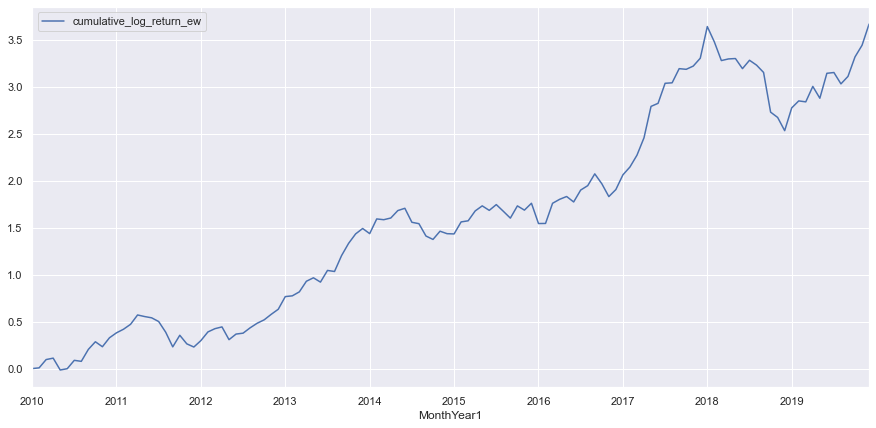

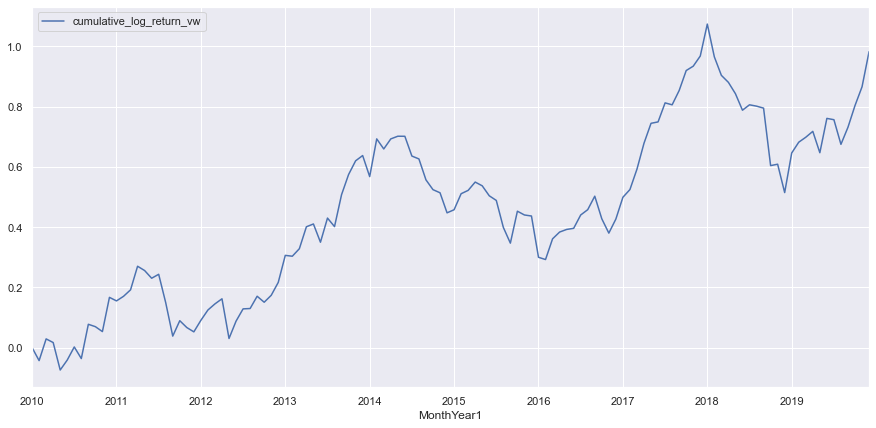

In [63]:
long =rank_9.copy()
long = long.set_index("MonthYear1")
long=long[["excess_return_portfolio_ew", "excess_return_portfolio_vw"]].drop_duplicates()

#Shift to get the returns in the current month
long["curr_ret_port_ew"]=long['excess_return_portfolio_ew'].shift(1)
long["curr_ret_port_vw"]=long['excess_return_portfolio_vw'].shift(1)

#Calculate cumulative returns and cumulative log returns for the equal weighting scheme
long["cumulative_return_ew"]= (1 + long["curr_ret_port_ew"]).cumprod()-1
long["cumulative_log_return_ew"]= (1 + np.log(long["curr_ret_port_ew"]+1)).cumprod()-1
# return in January 2010 = 0 (one invests in the end of the month)
long.iloc[0, 2:] = 0
#Plot cumulative log returns for the equal weighting scheme
long[["cumulative_log_return_ew"]].plot(grid=True,figsize=(15, 7))

#Calculate cumulative returns and cumulative log returns for the value weighting scheme
long["cumulative_return_vw"]= (1 + long["curr_ret_port_vw"]).cumprod()-1
long["cumulative_log_return_vw"]= (1 + np.log(long["curr_ret_port_vw"]+1)).cumprod()-1
# Return in January 2010 = 0(one invests in the end of the month)
long.iloc[0, 2:] = 0
# Plot cumulative log returns for the  value weighting scheme
long[["cumulative_log_return_vw"]].plot(grid=True,figsize=(15, 7));

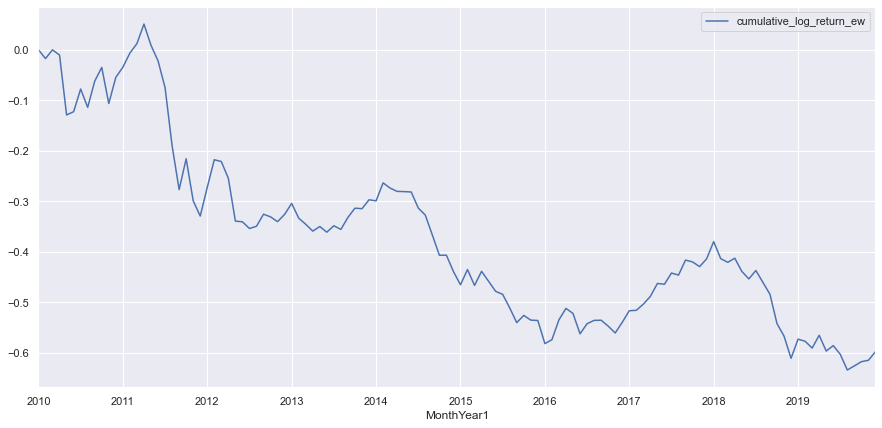

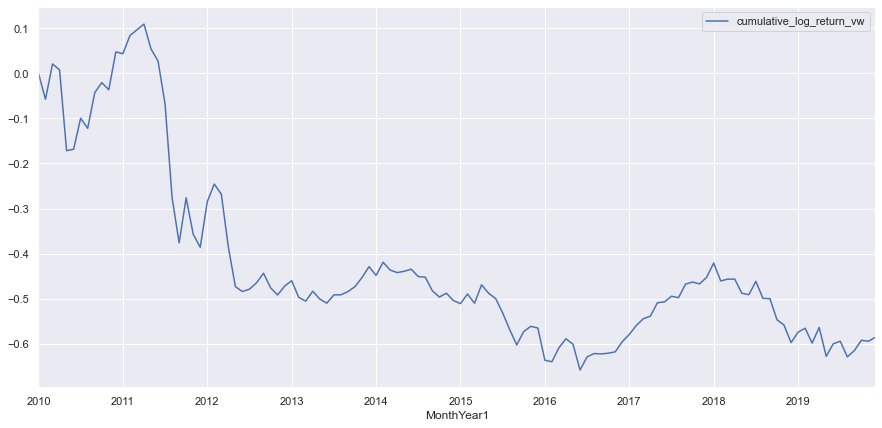

In [64]:
short =rank_0.copy()
short = short.set_index("MonthYear1")
short=short[["excess_return_portfolio_ew", "excess_return_portfolio_vw"]].drop_duplicates()

#Shift to get the returns in the current month
short["curr_ret_port_ew"]=short['excess_return_portfolio_ew'].shift(1)
short["curr_ret_port_vw"]=short['excess_return_portfolio_vw'].shift(1)

#Calculate cumulative returns and cumulative log returns for the equal weighting scheme
short["cumulative_return_ew"]= (1 + short["curr_ret_port_ew"]).cumprod()-1
short["cumulative_log_return_ew"]= (1 + np.log(short["curr_ret_port_ew"]+1)).cumprod()-1
# return in January 2010 = 0 (one invests in the end of the month)
short.iloc[0, 2:] = 0
#Plot cumulative log returns for the equal weighting scheme
short[["cumulative_log_return_ew"]].plot(grid=True,figsize=(15, 7))

#Calculate cumulative returns and cumulative log returns for the value weighting scheme
short["cumulative_return_vw"]= (1 + short["curr_ret_port_vw"]).cumprod()-1
short["cumulative_log_return_vw"]= (1 + np.log(short["curr_ret_port_vw"]+1)).cumprod()-1
# Return in January 2010 = 0(one invests in the end of the month)
short.iloc[0, 2:] = 0
# Plot cumulative log returns for the  value weighting scheme
short[["cumulative_log_return_vw"]].plot(grid=True,figsize=(15, 7));

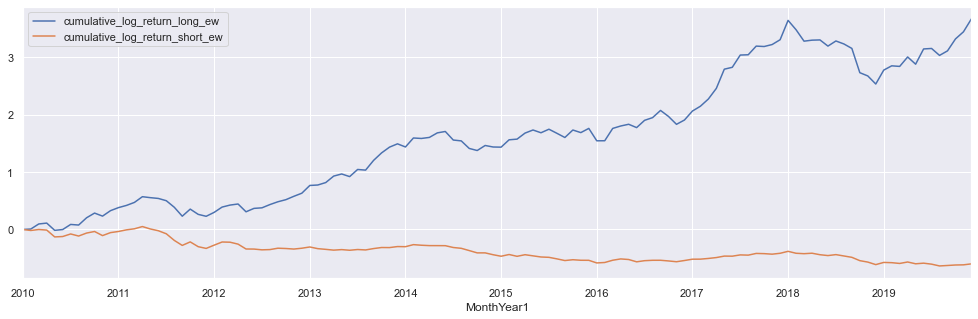

In [65]:
#Merge results to compare cumulative returns of both portfolios for the equal weighting scheme
long = long.rename(columns={'cumulative_log_return_ew': 'cumulative_log_return_long_ew'})
short = short.rename(columns={'cumulative_log_return_ew': 'cumulative_log_return_short_ew'})
long_short_ew = pd.merge(long[["cumulative_log_return_long_ew"]],short[["cumulative_log_return_short_ew"]],left_index=True, right_index=True)
#Plot
long_short_ew[["cumulative_log_return_long_ew", "cumulative_log_return_short_ew"]].plot(grid=True,figsize=(17, 5));

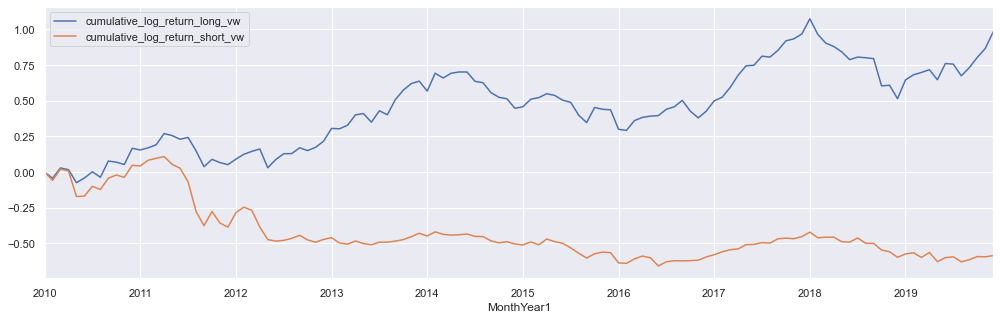

In [66]:
#Merge results to compare cumulative returns of both portfolios for the value weighting scheme
long = long.rename(columns={'cumulative_log_return_vw': 'cumulative_log_return_long_vw'})
short = short.rename(columns={'cumulative_log_return_vw': 'cumulative_log_return_short_vw'})
long_short_vw = pd.merge(long[["cumulative_log_return_long_vw"]],short[["cumulative_log_return_short_vw"]],left_index=True, right_index=True)
#Plot
long_short_vw[["cumulative_log_return_long_vw", "cumulative_log_return_short_vw"]].plot(grid=True,figsize=(17, 5));

# DAX Returns

Compare the cumulative returns of both portfolios with DAX cumulative returs over the same period

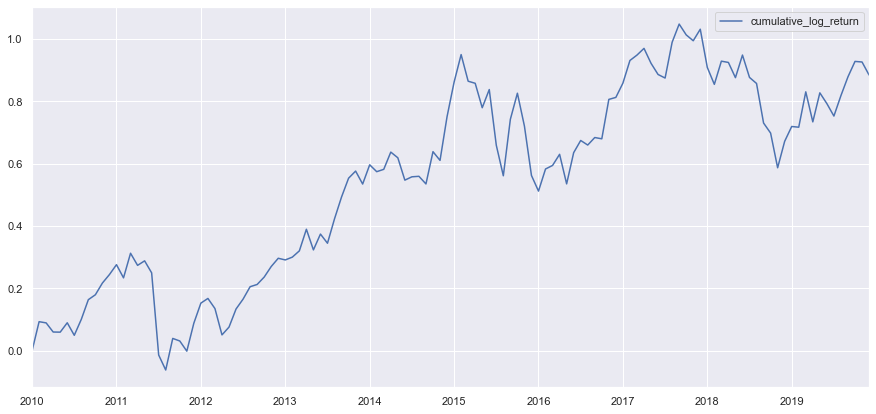

In [67]:
# calculate cumulative returns
dax["cumulative_return"]= (1 + dax["monthly_excess_return_dax"]).cumprod()-1
dax["cumulative_log_return"]= (1 + np.log(dax["monthly_excess_return_dax"]+1)).cumprod()-1

#replace NaN with 0: return and cumulative return on Jan 2010=0
dax.iloc[0,4:]=0
#plot
dax[["cumulative_log_return"]].plot(grid=True,figsize=(15, 7));

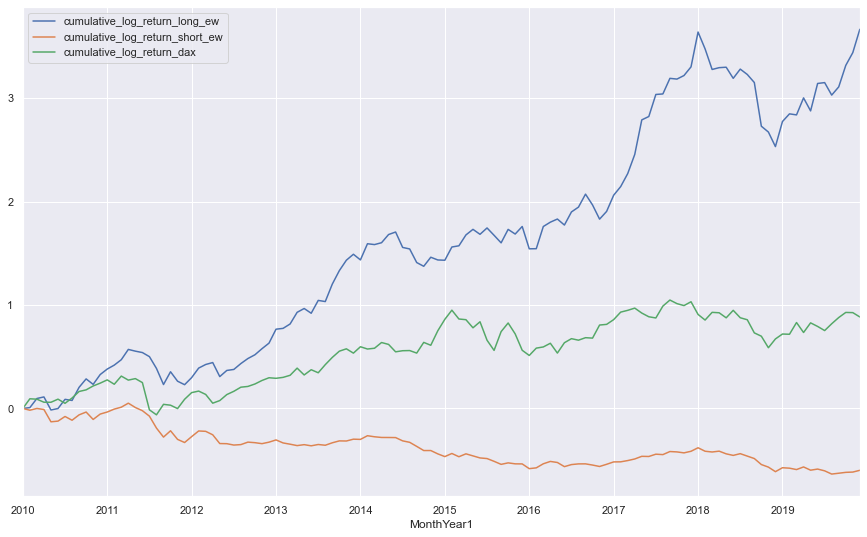

In [68]:
# Merge DAX cumulative log returns with the cumulative log returns of the equally weighted portfolios and plot
dax = dax.rename(columns={'cumulative_log_return': 'cumulative_log_return_dax'})
long_short_dax_ew = pd.merge(long_short_ew,dax[["cumulative_log_return_dax"]],left_index=True, right_index=True)    
long_short_dax_ew[["cumulative_log_return_long_ew", "cumulative_log_return_short_ew","cumulative_log_return_dax"]].plot(grid=True,figsize=(15, 9));

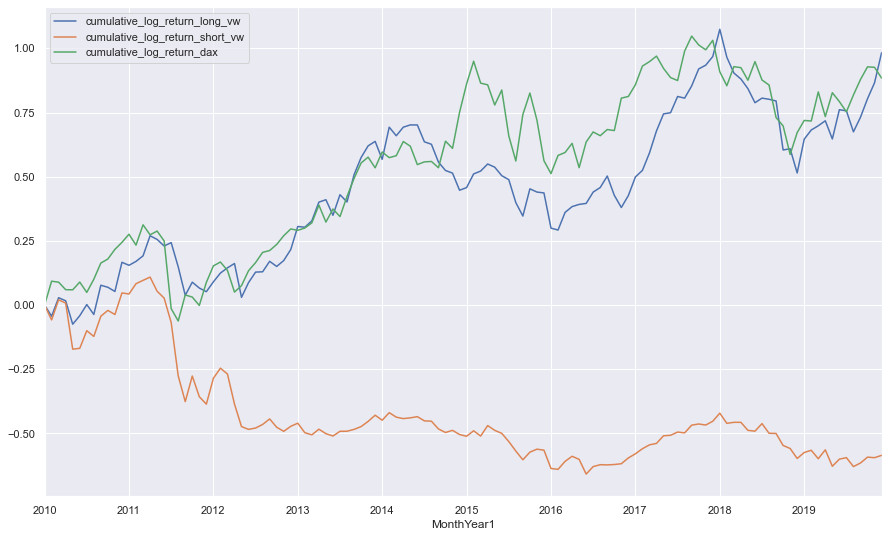

In [69]:
# Merge DAX cumulative log returns with the cumulative log returns of the value weighted portfolios and plot
dax = dax.rename(columns={'cumulative_log_return': 'cumulative_log_return_dax'})
long_short_dax_vw = pd.merge(long_short_vw,dax[["cumulative_log_return_dax"]],left_index=True, right_index=True)   
long_short_dax_vw[["cumulative_log_return_long_vw", "cumulative_log_return_short_vw","cumulative_log_return_dax"]].plot(grid=True,figsize=(15, 9));

In [70]:
# Save results to compare with the other ML models
long_short_dax_ew.to_csv(r'C:\Users\krist\Documents\Data\cumulative_log_returns\pcr_ew.csv')
long_short_dax_vw.to_csv(r'C:\Users\krist\Documents\Data\cumulative_log_returns\pcr_vw.csv')